### Description: Sparse Bayesian learning
#### Assumptions: scalar input, scalar output

###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

Bayesian linear regression is a probabilistic framework to estimate the parameters of a linear-in-parameter models using Bayesian inference. When using conjugate prior distribution for the model parameters, Bayesian linear regression provides analytical solution to the posterior parameter pdf, model evidence, and posterior predictive distribution. In matrix notation
\begin{align*}
\text{Observations:  } \;\; & Y \in \mathbb{R}^{M \times 1}  = \{y_1,y_2,\ldots,y_{M}\}^T \\
\text{Model input: } \;\; & X \in \mathbb{R}^{d \times 1}  = \{x_1,x_2,\ldots,x_{d}\}^T \\
\text{Model parameter: } \;\; & W \in \mathbb{R}^{N \times 1}  = \{w_0,w_1,\ldots,w_{N-1}\}^T \\
\text{Measurement error: } \;\; & \epsilon \in \mathbb{R}^{M \times 1}  = \{\varepsilon_0,\varepsilon_1,\ldots,\varepsilon_{M}\}^T \\
\text{Design matrix:  } \;\; & \Phi \in \mathbb{R}^{M \times N} = \{\phi_j(X_i); i =1,\ldots,M; j = 0,\ldots,N-1\}
\end{align*}
Assuming conjugate priors, Bayesian inference provides following analytical solution to the inverse problem:
\begin{align*}
\text{Model: } \;\;& Y = \Phi W + \epsilon \\
\text{Measurement noise: }\;\;& p(\epsilon) = \mathcal{N}(0,\frac{I_M}{\rho})\\
\text{Prior pdf: }\;\;& p(W) = \mathcal{N}(W|0, A^{-1})\;; \; A = \text{Diag}(\alpha)\;; \; \alpha = \{\alpha_0,\alpha_1,\ldots,\alpha_{N-1}\}\\
\text{Likelihood function: }\;\;& p(Y|W,\rho) = \mathcal{N}(Y|\Phi W,\frac{I_M}{\rho}) \\
\text{Posterior parameter pdf: }\;\; & p(W|Y,\rho) = \mathcal{N}(W|m,P)\\
& m = \frac{\rho \Phi^T \Phi}{P^{-1}} (\Phi^T\Phi)^{-1}\Phi^T Y \\
& P^{-1} = A + \rho \Phi^T \Phi \\
\text{Evidence: }\;\; & p(Y|\alpha,\rho) = \mathcal{N}(Y| 0, \Phi A^{-1}\Phi^T + \frac{I_M}{\rho})\\
\text{Predictive distribution: }\;\; & p(Y^*|Y) = \mathcal{N}(Y^*|\Phi^* m, (\Phi^* P(\Phi^*)^T) +\frac{I_M}{\rho})\\
\end{align*}
The maximization of evidence can be performed analytically and the resulting equaitons are:
\begin{align*}
\text{Given } \alpha,m,P: \;\;&\alpha_i^{new} = \frac{1- \alpha_i P_{i,i} + 2a}{m_i^2 + 2b} \\
& \rho_i^{new} = \frac{M- \sum_i (1- \alpha_i P_{i,i}) + 2c}{(Y-\Phi m)^T(Y-\Phi m) + 2d}
\end{align*}

In [1]:
#!/usr/bin/python
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import os, math, sys

Assign polynomial basis (polyPower), hyper-parameters a,b,c,d and initial hyperparameter $\alpha$ and noise precision $\rho$:

In [2]:
polyPower = [0,1,2,3,4,5,6] # powers of polynomial basis
N = len(polyPower) # number of coefficients 
alpha = [1e-04]*N # initial hyperparameter vector
rho = 20
a = 1e-08
b = 1e-08
c = 1e-08
d = 1e-08

Generate design matrix $\Phi$, and load observations $Y$ and input $X$: 

In [3]:
def PhiMat(X):
    M = len(X)
    Phi = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N):
            Phi[i,j] = X[i]**polyPower[j]
    return Phi
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
Phi = PhiMat(Xobs)
M = len(Yobs)

Sparse Bayesian leanring through Mckay's algorithm (similar to expectation maximizations):

In [4]:
def getEvid(alp,rh):
    return st.multivariate_normal.pdf(Yobs,[0]*M,np.matmul(Phi,np.matmul(np.linalg.inv(np.diag(alp)),np.transpose(Phi))) + np.identity(M)/rh)

def updatemP(alphai,rhoi):
    A = np.diag(alphai)
    Pi = np.linalg.inv(A + rhoi*np.matmul(np.transpose(Phi),Phi))
    mi = np.matmul(Pi,rhoi*np.matmul(np.transpose(Phi),Yobs))
    evidi = getEvid(alphai,rhoi)
    return mi, Pi, evidi

Run the sparse Bayesain learning loop to obtain optimal hyperparameter:

In [5]:
Ngrid = 1000
Wpost = np.zeros((N,Ngrid))
Wprior = np.zeros((N,Ngrid))
Wgrid = np.zeros((N,Ngrid))
alphaNew = alpha
rhoNew = rho
KLdis = [0]*N
gam = [0]*N
evidIter = []
rhoIter = []
gofIter = []
alphaIter = np.array([])
KLdisIter = np.array([])
evidNew = 1e-12
evid = 1e-20
j=0
while (np.log(evidNew) > np.log(evid) or j < 40):
    j = j+1
    alpha = alphaNew
    rho = rhoNew
    evid = evidNew
    m,P,evidNew = updatemP(alpha,rho)
    for i in range(0,N):
        gam[i] = 1 - alpha[i]*P[i,i]
        alphaNew[i] = (gam[i] + 2*a)/((m[i]**2)+2*b)
        Wmaxi = max(6/np.sqrt(alpha[i]),m[i]+6*np.sqrt(P[i,i]))
        Wmini = min(-6/np.sqrt(alpha[i]),m[i]-6*np.sqrt(P[i,i]))
        Wgrid[i,:] = np.linspace(Wmini,Wmaxi,Ngrid)
        Wpost[i,:] = st.multivariate_normal.pdf(Wgrid[i,:],m[i],P[i,i])
        Wprior[i,:] = st.multivariate_normal.pdf(Wgrid[i,:],0,1/alpha[i])
        KLdis[i] = st.entropy(Wpost[i,:],Wprior[i,:]) 
    rhoNew = (M - np.sum(gam) + 2*c)/(np.linalg.norm(Yobs-np.matmul(Phi,m))+2*d)
    Gof = st.multivariate_normal.pdf(Yobs,np.matmul(Phi,m),np.identity(M)/rho)
#    print(alpha,np.log(evid))
    evidIter.append(evid)
    rhoIter.append(rho)
    gofIter.append(Gof)
    alphaIter = np.append(alphaIter,alpha,axis=0)
    KLdisIter = np.append(KLdisIter,KLdis,axis=0)
print(alpha,np.log(evid))
print(m,'\n',np.diag(P))

[0.8145474145646783, 22238.244665033148, 1.2693257088229035, 62357.38863533647, 202157.99768993395, 496385.17930600716, 1122743.4855137712] -0.750776450619945
[1.10592245e+00 6.70263801e-05 8.86656687e-01 3.56435308e-05
 3.38376721e-05 3.87604832e-05 4.54183741e-05] 
 [4.61115590e-03 4.49380309e-05 1.65977738e-03 1.61844048e-05
 5.02929532e-06 1.98089366e-06 8.68640781e-07]


## Plotting for SBL iteration

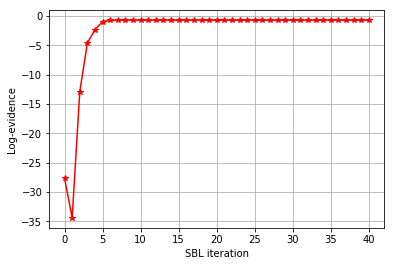

In [6]:
plt.figure(1)
plt.plot(np.log(evidIter),'r*')
plt.plot(np.log(evidIter),'r-')
plt.grid(True)
plt.ylabel('Log-evidence')
plt.xlabel('SBL iteration'); 

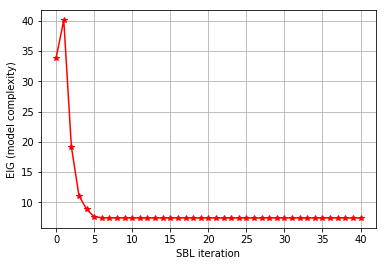

In [7]:
plt.figure(1)
plt.plot(np.log(gofIter) - np.log(evidIter),'r*')
plt.plot(np.log(gofIter) - np.log(evidIter),'r-')
plt.grid(True)
plt.ylabel('EIG (model complexity)')
plt.xlabel('SBL iteration'); 

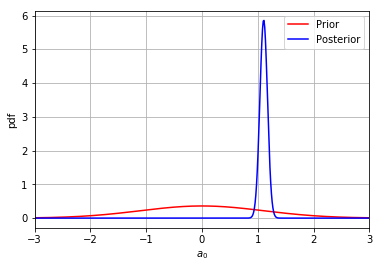

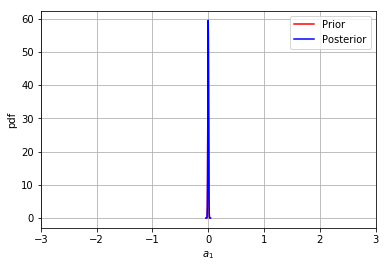

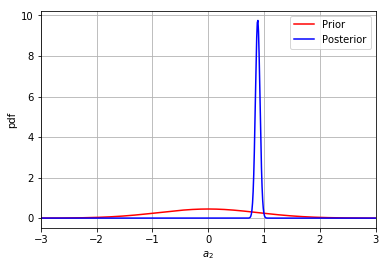

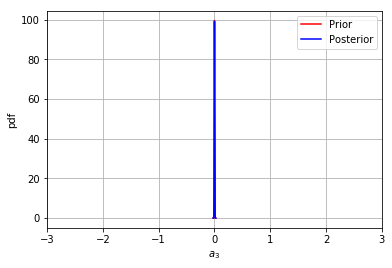

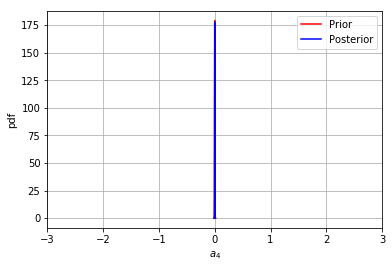

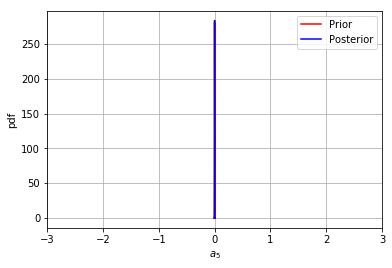

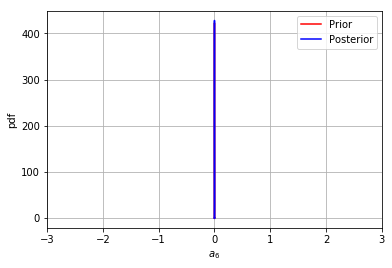

In [8]:
for i in range(0,N):
    fig = plt.figure(5+i)
    plt.plot(Wgrid[i,:],Wprior[i,:],'r-',label='Prior')
    plt.plot(Wgrid[i,:],Wpost[i,:],'b-',label='Posterior')
    plt.grid(True)
    plt.xlabel(r'$a_'+str(i)+'$')
    plt.ylabel('pdf')
    plt.xlim([-3,3])
    plt.legend(loc='best', numpoints = 1)
    plt.savefig('BLR_PDF_W'+str(i)+'.pdf',bbox_inches='tight')

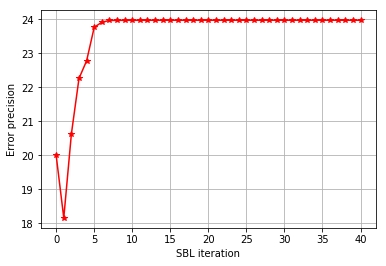

In [9]:
plt.figure(2)
plt.plot(rhoIter,'r*')
plt.plot(rhoIter,'r-')
plt.grid(True)
plt.ylabel('Error precision')
plt.xlabel('SBL iteration');

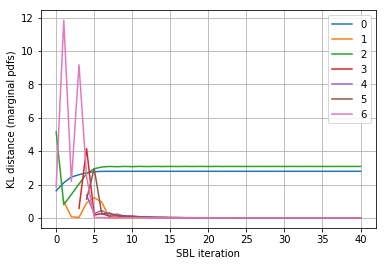

In [10]:
plt.figure(3)
for i in range(0,N):
    plt.plot(KLdisIter[i::N],label=str(i))
plt.grid(True)
plt.ylabel('KL distance (marginal pdfs)')
plt.xlabel('SBL iteration')
plt.legend(loc='best', numpoints = 1);

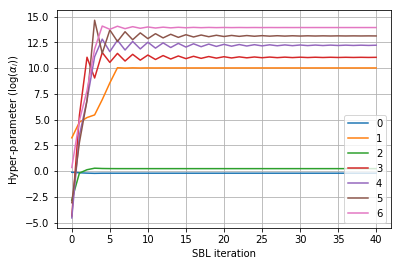

In [11]:
plt.figure(4)
for i in range(0,N):
    plt.plot(np.log(alphaIter[i::N]),label=str(i))
plt.grid(True)
plt.ylabel(r'Hyper-parameter ($\log(\alpha_i)$)')
plt.xlabel('SBL iteration')
plt.legend(loc='best', numpoints = 1);

In [12]:
Mnew = 100
Xextra = 2
Xnew = np.linspace(min(Xobs)-Xextra,max(Xobs)+Xextra,Mnew)
PhiNew = PhiMat(Xnew)
PredVar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/rho
PredMean = np.matmul(PhiNew,m)

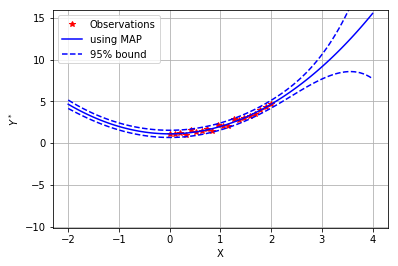

In [13]:
fig = plt.figure(N+1)
plt.plot(Xobs,Yobs,'r*',label='Observations')
plt.plot(Xnew,PredMean,'b-',label='using MAP')
plt.plot(Xnew,PredMean+2*np.sqrt(np.diag(PredVar)),'b--',label='95% bound')
plt.plot(Xnew,PredMean-2*np.sqrt(np.diag(PredVar)),'b--')
plt.grid(True)
plt.ylim([min(Yobs)-3*abs(max(Yobs)-min(Yobs)),max(Yobs)+3*abs(max(Yobs)-min(Yobs))])
plt.ylabel(r'$Y^*$')
plt.xlabel('X')
plt.legend(loc='best', numpoints = 1)
plt.savefig('BLR_predictions.pdf',bbox_inches='tight')
